In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import plotly.express as ex
import plotly.graph_objects as go

from scipy.stats import chi2

from tracking_v2.evaluation import Runner, evaluate_nees
from tracking_v2.kalman import InteractingMultipleModels, LinearKalmanFilter, CoordinatedTurn
from tracking_v2.motion import ConstantVelocityModel, ConstantAccelerationModel
from tracking_v2.sensor import GeometricSensor
from tracking_v2.target import SinusTarget
from tracking_v2.util import to_df, display, columns

In [4]:
def _plot_error_one(runner, skip=100):
    tm  = np.arange(runner.n-skip).reshape((runner.n-skip, -1))
    err = np.hstack((tm, np.abs(runner.one_x_hat[skip:,:3,0] - runner.truth[(skip+1):,:3])))
    err = to_df(err, columns=['time', 'x', 'y', 'z']).melt(['time'], ['x', 'y', 'z'], 'dim', 'error')
    return ex.line(err, x='time', y='error', facet_row='dim')

def _plot_error_many(runner, skip=100):
    tm  = np.arange(runner.n-skip)
    err = np.linalg.norm(runner.many_x_hat[:,skip:,:3,0] - runner.many_truth[:,(skip+1):,:3], axis=2)
    
    avg = np.array((tm, err.mean(axis=0))).T
    avg = to_df(avg, columns=['time', 'err'])
    avg['type'] = 'avg'
    
    low = np.array((tm, np.quantile(err, .025, axis=0))).T
    low = to_df(low, columns=['time', 'err'])
    low['type'] = '.025'
    
    upp = np.array((tm, np.quantile(err, .975, axis=0))).T
    upp = to_df(upp, columns=['time', 'err'])
    upp['type'] = '.975'

    err = pd.concat((avg, low, upp), axis=0).melt(['time', 'type'], ['err'], 'dim', 'error')
    return ex.line(err, x='time', y='error', color='type', facet_row='dim')

def _plot_nees(runner, skip=100):
    nees = evaluate_nees(runner.many_x_hat[:, :, :3, :], runner.many_P_hat[:, :, :3, :3], runner.many_truth[:, 1:, :3])
    err = np.asarray((np.arange(runner.n-skip), nees.scores[:,skip:].mean(axis=0))).T
    err = to_df(err, columns=['time', 'nees'])
    fig = ex.line(err, x='time', y='nees')
    
    ci = sp.stats.chi2.ppf([0.025, 0.975], runner.m * nees.dim) / runner.m
    fig.add_hline(y=ci[0], line_width=.5, line_dash="dash", line_color="red")
    fig.add_hline(y=ci[1], line_width=.5, line_dash="dash", line_color="red")

    return fig

In [5]:
class ImmRunner(Runner):
    one_mu_j = []
    many_mu_j = []

    def after_update(self, m):
        self.one_mu_j.append(self.kf.mu_j)

    def before_one(self):
        super().before_one()
        self.one_mu_j = []
    
    def after_one(self):
        super().after_one()
        self.one_mu_j = np.array(self.one_mu_j)
        self.many_mu_j.append(self.one_mu_j)
    
    def after_many(self):
        super().after_many()
        self.many_mu_j = np.array(self.many_mu_j)

def _plot_mu_j(runner):
    df = np.hstack((np.arange(runner.one_mu_j.shape[0]).reshape((-1, 1)), runner.one_mu_j, target.heading().reshape((-1, 1))))
    df = to_df(df, columns=['time', 'p0', 'p1', 'p2', 'heading'])
    return ex.line(df.melt(['time'], ['p0', 'p1', 'p2'], 'model', 'prob'), x='time', y='prob', color='model')

In [6]:
def _create_imm():
    cv = LinearKalmanFilter(ConstantVelocityModel(noise_intensity=0.1),
                            [[1, 0, 0, 0, 0, 0],
                             [0, 1, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0, 0]])
    
    ca = LinearKalmanFilter(ConstantAccelerationModel(noise_intensity=0),
                            [[1, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 1, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0, 0, 0, 0, 0]])
    
    ct = CoordinatedTurn([1, 1, 1, 0.02289])
    
    def linear_extend(filter_x_hat, filter_P_hat):
        x, P = np.zeros((9, 1)), np.zeros((9, 9))
        x[:filter_x_hat.shape[0], :filter_x_hat.shape[1]] = filter_x_hat
        P[:filter_P_hat.shape[0], :filter_P_hat.shape[1]] = filter_P_hat
        return x, P
    
    def linear_trim(common_x_hat, common_P_hat, filter_x_hat, filter_P_hat):
        return common_x_hat[:6, :1], common_P_hat[:6, :6]
    
    def to_common_identity(filter_x_hat, filter_P_hat):
        return filter_x_hat, filter_P_hat
    
    def from_common_identity(common_x_hat, common_P_hat, filter_x_hat, filter_P_hat):
        return common_x_hat, common_P_hat
    
    def ct_to_common(x_hat, P_hat):
        x, P = np.zeros((9, 1)), np.zeros((9, 9))
        x[:6, :1] = x_hat[:6, :1]
        P[:6, :6] = P_hat[:6, :6]
        return x, P
    
    def ct_from_common(common_x_hat, common_P_hat, filter_x_hat, filter_P_hat):
        filter_x_hat[:6, :1] = common_x_hat[:6, :1]
        filter_P_hat[:6, :6] = common_P_hat[:6, :6]
        return filter_x_hat, filter_P_hat
    
    filters = [
        (cv, linear_extend, linear_trim),
        (ca, to_common_identity, from_common_identity),
        (ct, ct_to_common, ct_from_common)
    ]
    
    imm = InteractingMultipleModels(filters, [[.95, .05, .0],
                                              [.33, .34, .33],
                                              [.0,  .05, .95]])

    return imm

In [7]:
def _create_ca():
    ca = LinearKalmanFilter(ConstantAccelerationModel(noise_intensity=1),
                        [[1, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 1, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 1, 0, 0, 0, 0, 0, 0]])
    return ca

# Sinus

In [8]:
target = SinusTarget(30, 3)
sensor = GeometricSensor(seed=0)
true_positions = target.true_states()

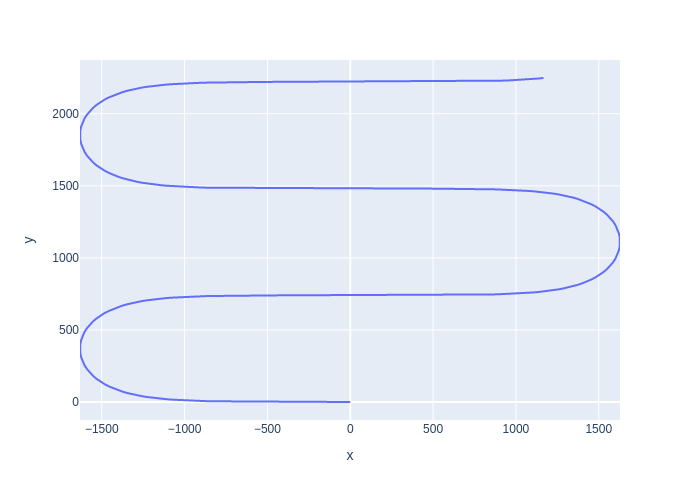

In [9]:
display(ex.line(x=true_positions[:, 0], y=true_positions[:, 1]))

## Probabilities of modes

In [10]:
runner = ImmRunner(target, sensor, _create_imm())
runner.run_one(400)

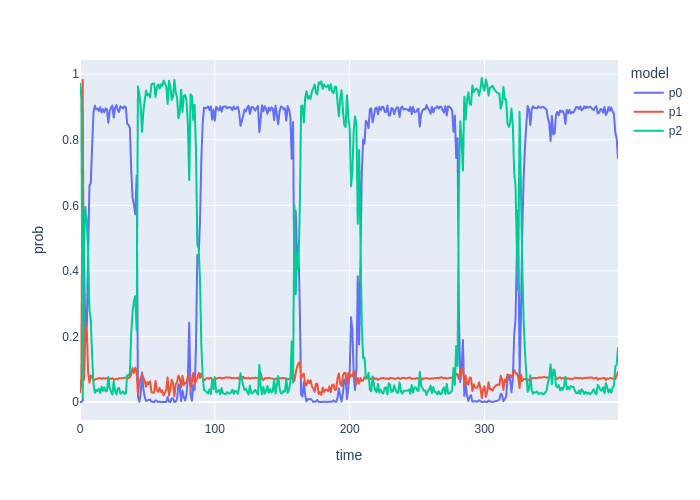

In [11]:
display(_plot_mu_j(runner))

## Errors

### CA

In [12]:
runner = Runner(target, sensor, _create_ca())
runner.run_many(m=100, n=400)

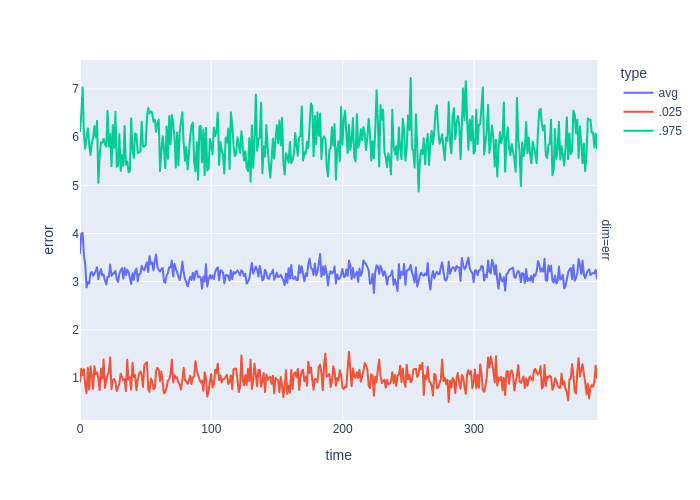

In [13]:
display(_plot_error_many(runner, skip=5))

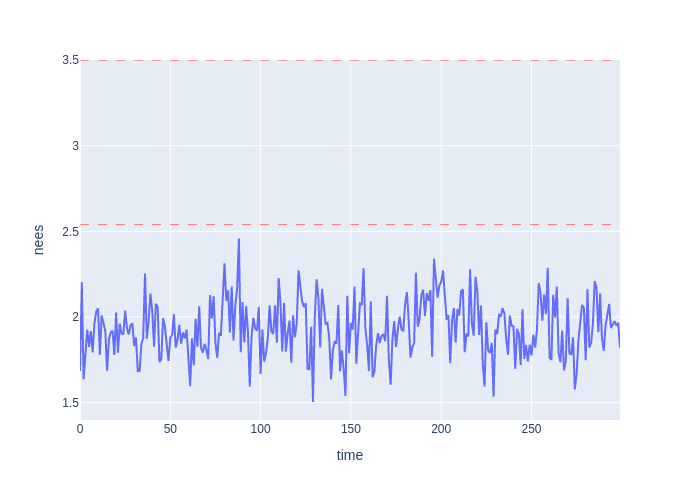

In [14]:
display(_plot_nees(runner))

### IMM

In [15]:
runner = ImmRunner(target, sensor, _create_imm())
runner.run_many(m=100, n=400)

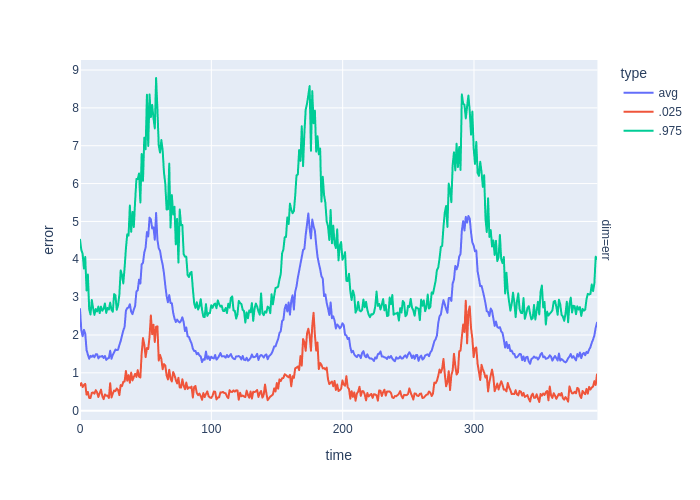

In [16]:
display(_plot_error_many(runner, skip=5))

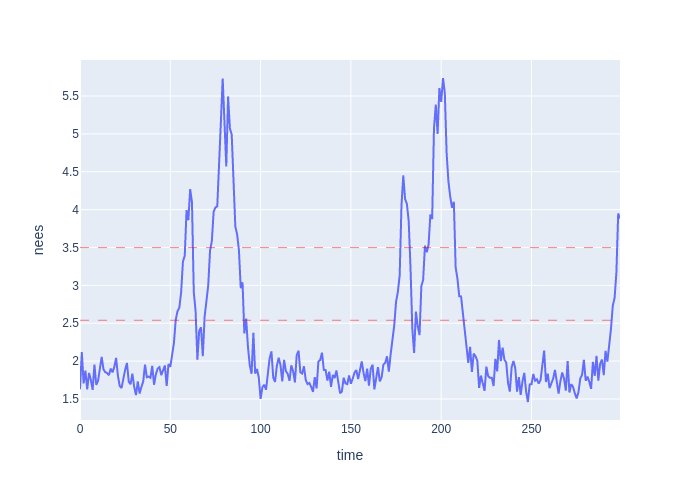

In [17]:
display(_plot_nees(runner))